In [1]:
import numpy as np
from hamming_distance_distribution import hamming_distance_distribution, hamming_distance_distribution_exhaustive
import matplotlib.pyplot as plt
import time

In [2]:
# --------- Parameters ---------
N_repeat = 200      # how many samples per neglection threshold

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

which_ctl_fct = 0   # 0: linear control function, 1: optimal control function

neglection_rule = 1 # 0: only smallest matrix element, 1: neglect below threshold, 2: neglect a certain number of couplings, 3: maximum degree given for all nodes
method = 1          # 0: compute complete annealing process, 1: do exhaustive search
# only relevant, if method == 0:
nb_pts_gap = 20     # number of points for the gap computation
nb_pts_time = 30    # number of points for resolution of the time dependant Schrodinger's equation
epsilon = 0.1       # precision level for the control function (valid for both, linear and optimal scheduling)
gamma = 1           # strength of the transverse field, irrelevant for us 


# runtime for these settings
T_hdd = 9*N_repeat/100       # runtime of function hamming_distance_distribution in seconds

In [3]:
# ----------- Program -----------
def sweep_neglection_param(neglection_rule, method=1):
    if method == 0:
        print(f"Estimated runtime of the program: {(T_hdd*N_thres)/60} min.")

    # activity pattern
    alpha = np.zeros(N)
    alpha[0] = 1
    alpha[2] = 1

    # iterating over the neglection thresholds
    if neglection_rule == 0:
        raise ValueError("No implementation for rule 0 (wouldn't make sense since with rule 0 just the smallest matrix element is neglected - no need to sweep something)")
    elif neglection_rule == 1:
        N_thres = 50
        neglection_thres = np.linspace(0, 1, N_thres)
    elif neglection_rule == 2:
        N_thres = int(N*(N-1)/2) +1
        neglection_thres = np.arange(0, N_thres)
    elif neglection_rule == 3:
        N_thres = N-1 +1                         # largest possible degree of a node is always N-1
        neglection_thres = np.arange(0, N_thres)

    d = np.arange(N)                        # hamming distance (x-axis)
    n = np.zeros(shape=(N_thres, N+1))      # number of occurences of that hamming distance (y-axis)
    N_n = np.zeros(N_thres)            # how many matrix elements were neglected (second y-axis)
    runtime_hdd = np.zeros(N_thres)
    connected_counter = np.zeros(N_thres)

    t0 = time.time()
    for i in range(N_thres):
        t0 = time.time()
        if method == 0:         # using simulation of complete annealing process
            distr = hamming_distance_distribution(N_repeat, N, M, alpha, K, xi, 1, neglection_thres[i], gamma, epsilon, which_ctl_fct, nb_pts_gap, nb_pts_time, False)
        elif method == 1:       # using exhaustive search
            distr = hamming_distance_distribution_exhaustive(N_repeat, N, M, alpha, K, xi, neglection_rule, neglection_thres[i], False)
        t1 = time.time()
        runtime_hdd[i] = t1-t0

        n[i] = distr[1]
        N_n[i] = distr[2]
        connected_counter[i] = distr[3]

    t1 = time.time()

    print(f"avg. runtime of hamming_distance_distribution: ({np.mean(runtime_hdd):.3f} +- {np.std(runtime_hdd):.3f})s.")

    return neglection_thres, n, N_n, connected_counter, d



----------------------------- neglection rule 1 ----------------------------------
avg. runtime of hamming_distance_distribution: (0.205 +- 0.062)s.


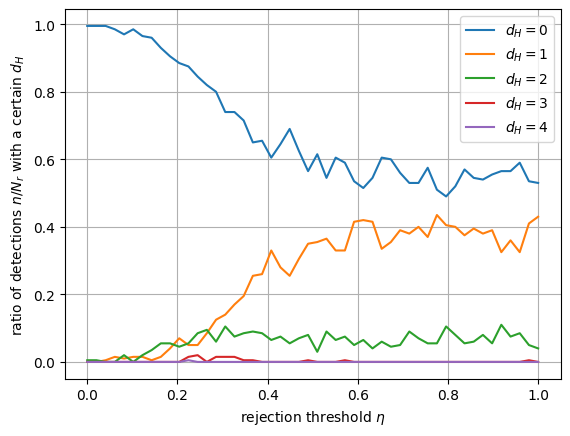

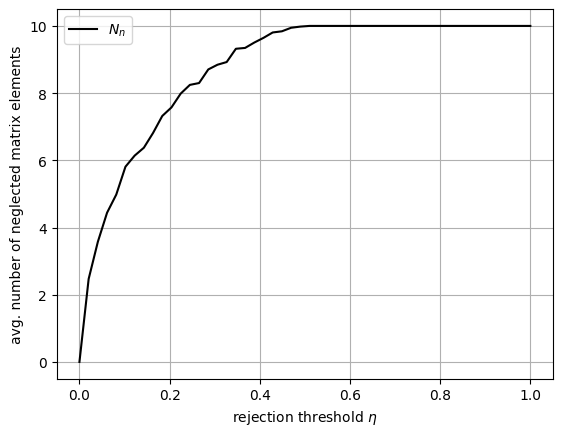

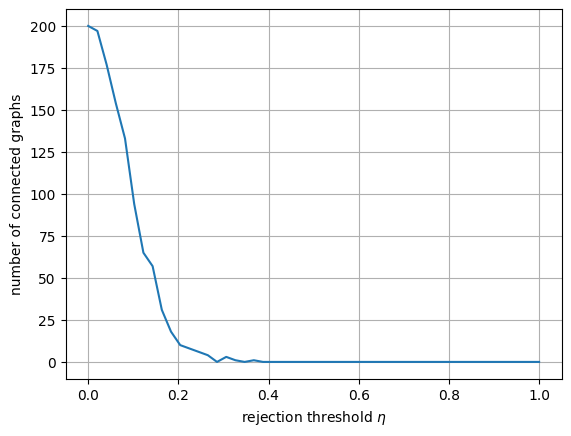

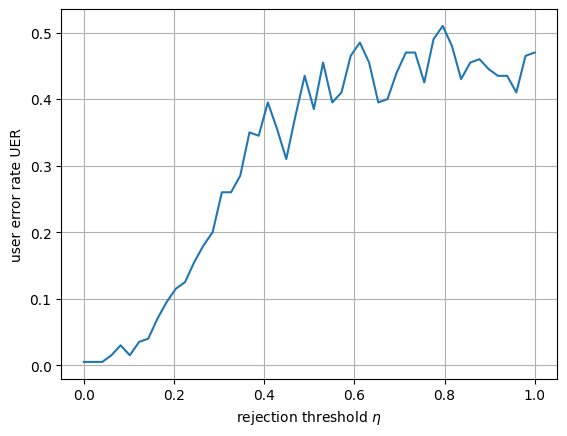

----------------------------- neglection rule 2 ----------------------------------
avg. runtime of hamming_distance_distribution: (0.183 +- 0.018)s.


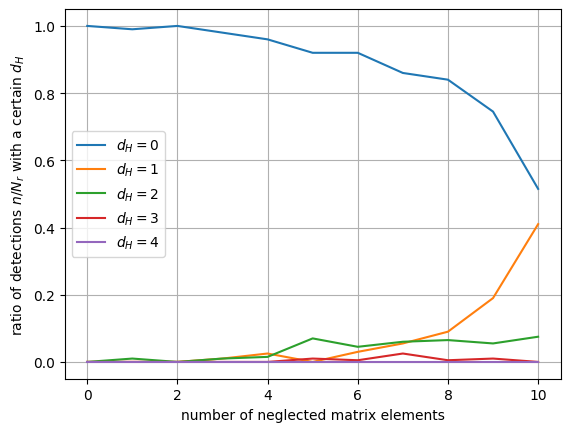

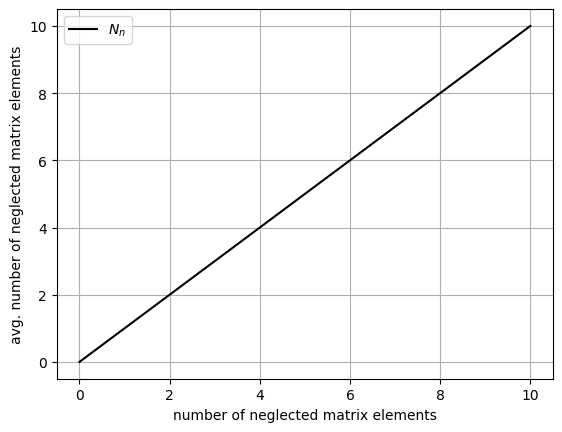

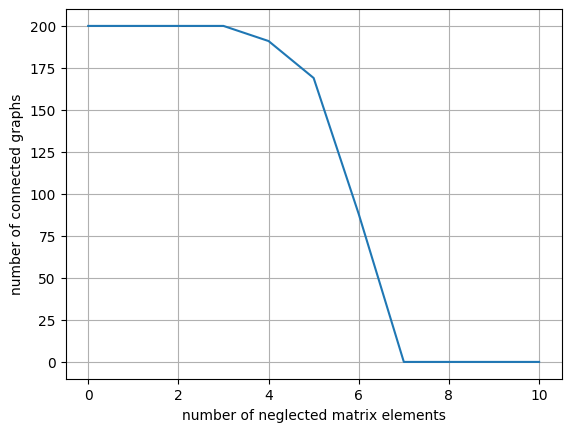

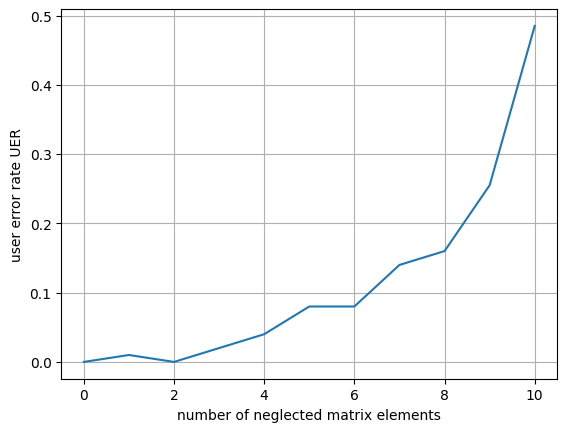

----------------------------- neglection rule 3 ----------------------------------
avg. runtime of hamming_distance_distribution: (0.260 +- 0.011)s.


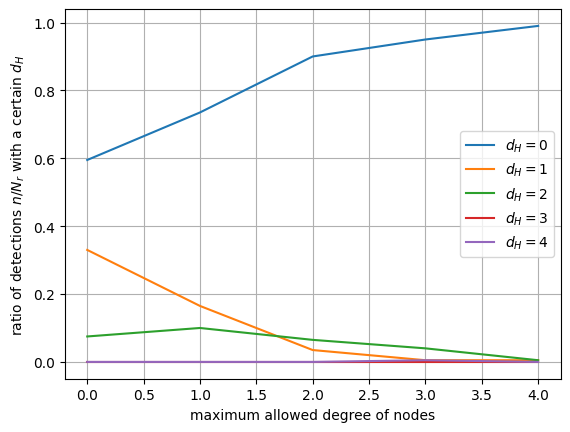

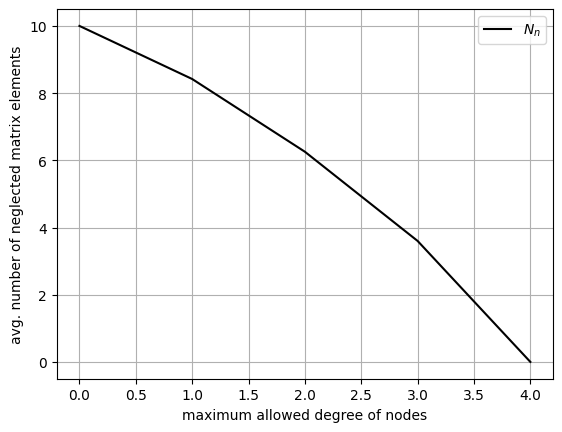

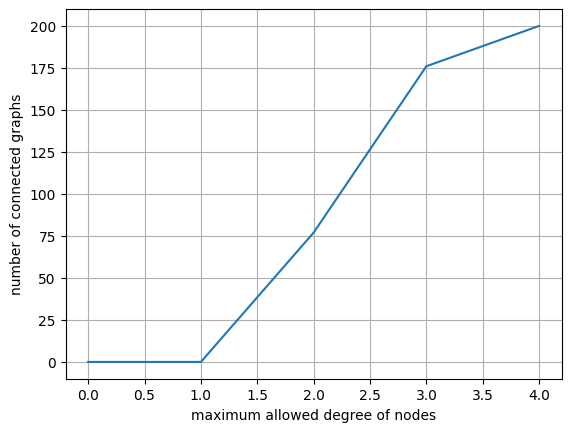

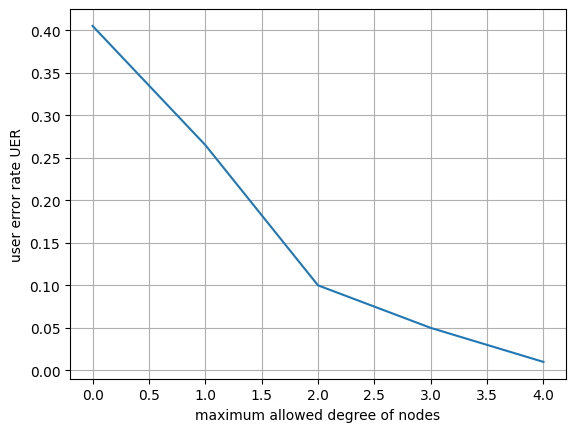

In [ ]:

#print("Note: in approx. 6% of cases, QuTip does not converge.")        # this is not important because the converging happens when calculating the complete time evolution. However, the function hamming_distance_distribution deactivates this calculation as it is not necessary for the determination of the Hamming distance.

# ---------- Plotting for each rule ----------

x_labels = ["", r"rejection threshold $\eta$", "number of neglected matrix elements", "maximum allowed degree of nodes"]

for neglection_rule in [1, 2, 3]:
    print(f"----------------------------- neglection rule {neglection_rule} ----------------------------------")
    
    neglection_thres, n, N_n, connected_counter, d = sweep_neglection_param(neglection_rule)

    # Hamming distances
    fig = plt.figure()
    #axl = fig.add_subplot()
    #axr = axl.twinx()


    for j in range(N):
        plt.plot(neglection_thres, n[:, j]/N_repeat, label=rf"$d_H={d[j]}$")
    plt.xlabel(x_labels[neglection_rule])
    plt.ylabel(r"ratio of detections $n/N_r$ with a certain $d_H$")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(neglection_thres, N_n, label=r"$N_n$", color="black")
    plt.xlabel(x_labels[neglection_rule])
    plt.ylabel("avg. number of neglected matrix elements")
    #plt.legend()
    plt.grid()
    plt.show()


    plt.plot(neglection_thres, connected_counter)
    plt.xlabel(x_labels[neglection_rule])
    plt.ylabel("number of connected graphs")
    plt.grid()
    plt.show()

    # complete user error rate between both annealing results (nothing new - just the same data represented differently)
    plt.plot(neglection_thres, 1-n[:, 0]/N_repeat)
    plt.xlabel(x_labels[neglection_rule])
    plt.ylabel("user error rate UER")
    plt.grid()
    plt.show()
    # note: The UER in this case is the UER between the detection result of the annealing with neglected and without neglected matrix elements. Thus, it starts at zero. However, the detection without neglected matrix elements might also have a certain error rate.
